# matplotlib 한국어 지원 폰트로 바꿔주기

In [5]:
# 폰트 파일 다운로드 및 경로 확인
!wget "https://github.com/naver/nanumfont/raw/master/releases/NanumBarunGothic.ttf" -O NanumBarunGothic.ttf
!ls -la NanumBarunGothic.ttf  # 파일이 제대로 다운로드 되었는지 확인

--2025-05-19 10:56:55--  https://github.com/naver/nanumfont/raw/master/releases/NanumBarunGothic.ttf
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-05-19 10:56:55 ERROR 404: Not Found.

-rw-r--r-- 1 root root 0 May 19 10:56 NanumBarunGothic.ttf


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

import matplotlib.font_manager as fm
fontpath = '/content/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic')
mpl.font_manager.findfont(font)

print("완료!")

완료!


# 데이터 준비하기

In [5]:
!pip install tensorflow

In [6]:
import tensorflow as tf
import numpy as np
import pandas

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

print(tf.__version__)

2.18.0


In [7]:
import tarfile

file_path = "/content/korean-english-park.train.tar.gz"
extract_path = "/content/"

with tarfile.open(file_path, "r:gz") as tar:
    tar.extractall(path=extract_path)

path_to_file = "/content/korean-english-park.train.ko"

In [8]:
with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))
print("Example:")

for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [9]:
en_path = "/content/korean-english-park.train.en"
ko_path = "/content/korean-english-park.train.ko"
merged_path = "/content/merged.txt"

# 병합 파일 쓰기
with open(en_path, 'r', encoding='utf-8') as en_file, \
     open(ko_path, 'r', encoding='utf-8') as ko_file, \
     open(merged_path, 'w', encoding='utf-8') as out_file:

    for en_line, ko_line in zip(en_file, ko_file):
        en_line = en_line.strip()
        ko_line = ko_line.strip()

        if en_line and ko_line:
            out_file.write(f"{en_line}\t{ko_line}\n")

# 파일 열고 모든 줄 읽어서 리스트로 저장
with open(merged_path, "r", encoding="utf-8") as f:
    data = f.read().splitlines()

print("Data Size:", len(data))
print("Example:")

for sen in data[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"	개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.	북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.	"경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.	수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.	또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 

# 데이터 전처리: 정제하기

In [10]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^가-힣a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'

    return sentence

print("슝~")

슝~


In [11]:
cleaned_corpus = list(set(data))

print("Data Size:", len(cleaned_corpus))
print("Example:")

for sen in cleaned_corpus[0:100][::20]: print(">>", sen)

Data Size: 78941
Example:
>> The blasts were so strong six houses and several shops were damaged.	폭발은 너무나 강해 사고지점 인근 집 6채와 상점이 파손됐다.
>> Microsoft`s Ballmer touts `best version of Windows ever`	2009.01.09 08:59 입력 / 2009.01.09 11:44 수정
>> His brief includes Palestinian governance, economics and security rather than the wider conflict between Israel and Palestinians - at least initially.	그의 짧은 발표문에는, 적어도 최초에는, 이스라엘과 팔레스타인 사이 의 광범위한 갈등 보다는 팔레스타인의 지배 구조, 경제, 그리고 보안에 관한 내용만이 포함되어 있었다.
>> She's also a publisher who runs Strebor Books, an imprint of Simon & Schuster with more than 50 authors, many of whom get a sales boost from their association with Zane.	그는 또한 다른 작가 50인과 함께 사이몬과 슈스터(Simon & Schuster)를 출간한 스트레버 북스(Strebor Books)를 운영하고 있으며 그들 중 대다수는 제인과 관련된 다른 판매 상품을 가지고 있다.
>> By the time work crews diverted the leak to proper drainage and placed a patch over the leak, about 20 barrels of water had escaped from the pipe.	그에따르면 작업 인부들이 수리하기 위해 이곳에 도착했을 때 이미 20 배렐의 물이 빠져나간 뒤였다.


In [12]:
enc_corpus = []
dec_corpus = []

num_examples = 30000

for pair in cleaned_corpus[:num_examples]:
    eng, kor = pair.split("\t")

    if len(eng.split()) <= 40 and len(kor.split()) <= 40:
        enc_corpus.append(preprocess_sentence(kor))
        dec_corpus.append(preprocess_sentence(eng, s_token=True, e_token=True))

print("Filtered Data Size:", len(enc_corpus))
print("Example:")
print("Korean:", enc_corpus[100])   # go away !
print("English:", dec_corpus[100])   # <start> salga de aqu ! <end>

Filtered Data Size: 28712
Example:
Korean: 그러나 이는 규격화된 시험에 대비한 기계적인 학습을 강조하는 압력밥솥 여건을 야기했냈다 .
English: <start> but it also created pressure cooker conditions that emphasize rote learning for standardized exams . <end>


# 데이터 전처리: 토큰화

In [13]:
# 필수 패키지
!sudo apt-get install -y mecab libmecab-dev mecab-ipadic-utf8 python3-dev

# konlpy 재설치
!pip install konlpy

# Mecab-ko for Colab 설치 (최신 가볍고 안정적인 스크립트)
!git clone --depth 1 https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
!bash Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab_light_220429.sh



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-dev is already the newest version (3.10.6-1~22.04.1).
python3-dev set to manually installed.
The following additional packages will be installed:
  libmecab2 mecab-ipadic mecab-utils
The following NEW packages will be installed:
  libmecab-dev libmecab2 mecab mecab-ipadic mecab-ipadic-utf8 mecab-utils
0 upgraded, 6 newly installed, 0 to remove and 89 not upgraded.
Need to get 7,367 kB of archives.
After this operation, 59.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libmecab2 amd64 0.996-14build9 [199 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libmecab-dev amd64 0.996-14build9 [306 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 mecab-utils amd64 0.996-14build9 [4,850 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 mecab-ipadic all 2.7.0-20070801+main-3 [6,718 kB]
Get:5 http://archive.ubun

In [14]:
from konlpy.tag import Mecab

mecab = Mecab()

In [15]:
# 한국어 토큰화 (KoNLPy - Mecab)
def tokenize_with_mecab(corpus):
    tokenized_corpus = []
    for sentence in corpus:
        tokens = mecab.morphs(sentence)  # 형태소 단위 분리
        tokenized_sentence = ' '.join(tokens)  # 공백으로 연결
        tokenized_corpus.append(tokenized_sentence)
    return tokenized_corpus

In [16]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [17]:
enc_corpus_tok = tokenize_with_mecab(enc_corpus)

In [18]:
enc_tensor, enc_tokenizer = tokenize(enc_corpus_tok)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

In [19]:
print("원문 (한):", enc_corpus[0])
print("형태소:", enc_corpus_tok[0])
print("Tensor:", enc_tensor[0])

print("\n원문 (영):", dec_corpus[0])

print("Tensor:", dec_tensor[0])


원문 (한): 폭발은 너무나 강해 사고지점 인근 집 채와 상점이 파손됐다 .
형태소: 폭발 은 너무나 강해 사고 지점 인근 집 채 와 상점 이 파손 됐 다 .
Tensor: [  441     8  4078 11359   206  1711   428   316   362    28  1941     3
  1550    54     2     1     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0]

원문 (영): <start> the blasts were so strong six houses and several shops were damaged . <end>
Tensor: [   4    1 3397   32  122  553  190 1495   10  224 2548   32 1344    2
    5    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0

# 모델 설계하기

In [40]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)

    def call(self, h_enc, h_dec):
        # h_enc: (batch_size, max_length, units)
        # h_dec: (batch_size, units)

        # h_dec의 shape을 (batch_size, 1, units)로 변환
        if len(h_dec.shape) == 2:
            # 이미 batch_size가 포함된 경우
            h_dec = tf.expand_dims(h_dec, 1)
        elif len(h_dec.shape) == 1:
            # batch_size가 없는 경우 (오류 상황)
            # 먼저 shape 출력
            print(f"h_dec shape: {h_dec.shape}")

            # 1차원 텐서를 2차원으로 확장 후 다시 3차원으로
            h_dec = tf.expand_dims(tf.expand_dims(h_dec, 0), 1)
            print(f"변환 후 h_dec shape: {h_dec.shape}")

        # 변환된 텐서에 적용
        h_enc = self.w_enc(h_enc)
        h_dec = self.w_dec(h_dec)

        # 어텐션 스코어 계산
        score = self.w_com(tf.nn.tanh(h_dec + h_enc))

        # 어텐션 가중치 계산
        attention_weights = tf.nn.softmax(score, axis=1)

        # 컨텍스트 벡터 계산
        context_vector = attention_weights * h_enc
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [41]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [42]:
# class Decoder(tf.keras.Model):
#     def __init__(self, vocab_size, embedding_dim, dec_units):
#         super(Decoder, self).__init__()
#         self.dec_units = dec_units
#         self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
#         self.gru = tf.keras.layers.GRU(dec_units,
#                                        return_sequences=True,
#                                        return_state=True)
#         self.fc = tf.keras.layers.Dense(vocab_size)

#         self.attention = BahdanauAttention(self.dec_units)

#     def call(self, x, h_dec, enc_out):
#         context_vec, attn = self.attention(enc_out, h_dec)

#         out = self.embedding(x)
#         out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

#         out, h_dec = self.gru(out)
#         out = tf.reshape(out, (-1, out.shape[2]))
#         out = self.fc(out)

#         return out, h_dec, attn

In [54]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()

        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        # GRU 정의
        self.gru = tf.keras.layers.GRU(dec_units,
                                     return_sequences=True,
                                     dropout=0.3)

        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(dec_units)

    def call(self, x, hidden, enc_output):

        # hidden이 배치 차원이 없는 1차원 텐서인 경우
        if len(hidden.shape) == 1:
            # 배치 차원 추가
            batch_size = tf.shape(x)[0]
            hidden = tf.tile(tf.expand_dims(hidden, 0), [batch_size, 1])
        elif isinstance(hidden, tuple) and len(hidden) == 1:
            # hidden이 튜플인 경우 (GRUCell에서 발생할 수 있음)
            hidden_tensor = hidden[0]
            if len(hidden_tensor.shape) == 1:
                # 배치 차원 추가
                batch_size = tf.shape(x)[0]
                hidden = tf.tile(tf.expand_dims(hidden_tensor, 0), [batch_size, 1])
            else:
                hidden = hidden_tensor

        # 어텐션 계산
        context_vector, attention_weights = self.attention(enc_output, hidden)

        # 임베딩
        x = self.embedding(x)

        # 컨텍스트 벡터와 결합
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # GRU 처리
        outputs = self.gru(x, initial_state=hidden)

        # 마지막 상태 추출 (배치의 마지막 타임스텝의 출력)
        state = outputs[:, -1, :]

        # 출력 변환
        outputs = tf.reshape(outputs, (-1, outputs.shape[2]))

        # 단어 예측
        x = self.fc(outputs)

        return x, state, attention_weights

In [55]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 1024)
Decoder Output: (64, 29782)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


# Optimizer & Loss

In [56]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    return tf.reduce_mean(loss)

print("슝~")

슝~


# train_step() 구현하기

In [57]:
# @tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]

        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)

    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

print("슝~")

슝~


# 훈련 시작하기

In [58]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx+BATCH_SIZE],
                                dec_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 10: 100%|██████████| 449/449 [19:16<00:00,  2.58s/it, Loss 2.6233]


# 성능 평가하기 + Attention Map

Input: 오바마는 대통령이다 .
Predicted translation: the first . <end> 


<ipython-input-60-dc48aaffc8b9>:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-60-dc48aaffc8b9>:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


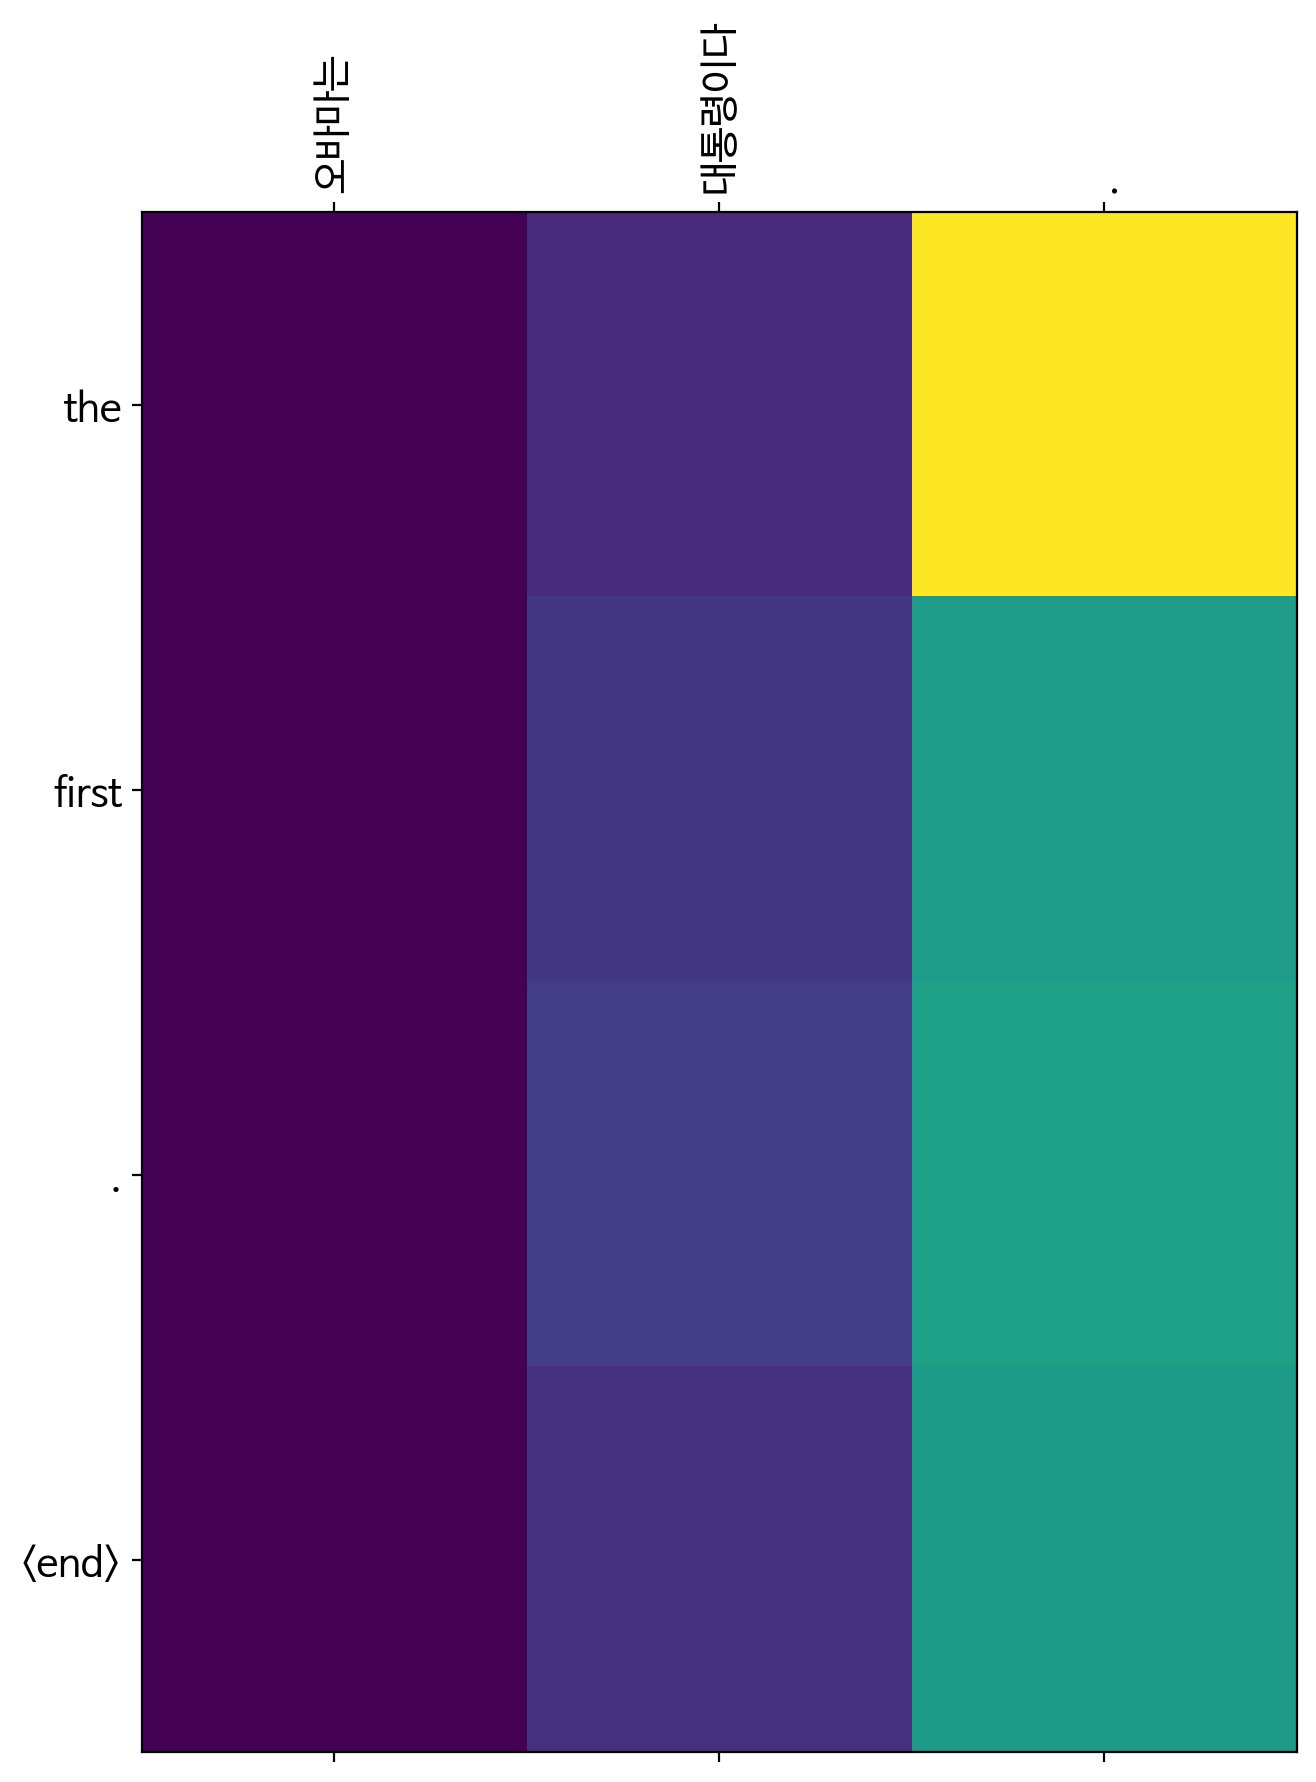

In [60]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_tensor.shape[-1], enc_tensor.shape[-1]))

    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_tensor.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))


translate("오바마는 대통령이다.", encoder, decoder)

Input: 시민들은 도시 속에 산다 .
Predicted translation: the first first first . <end> 


<ipython-input-60-dc48aaffc8b9>:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-60-dc48aaffc8b9>:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


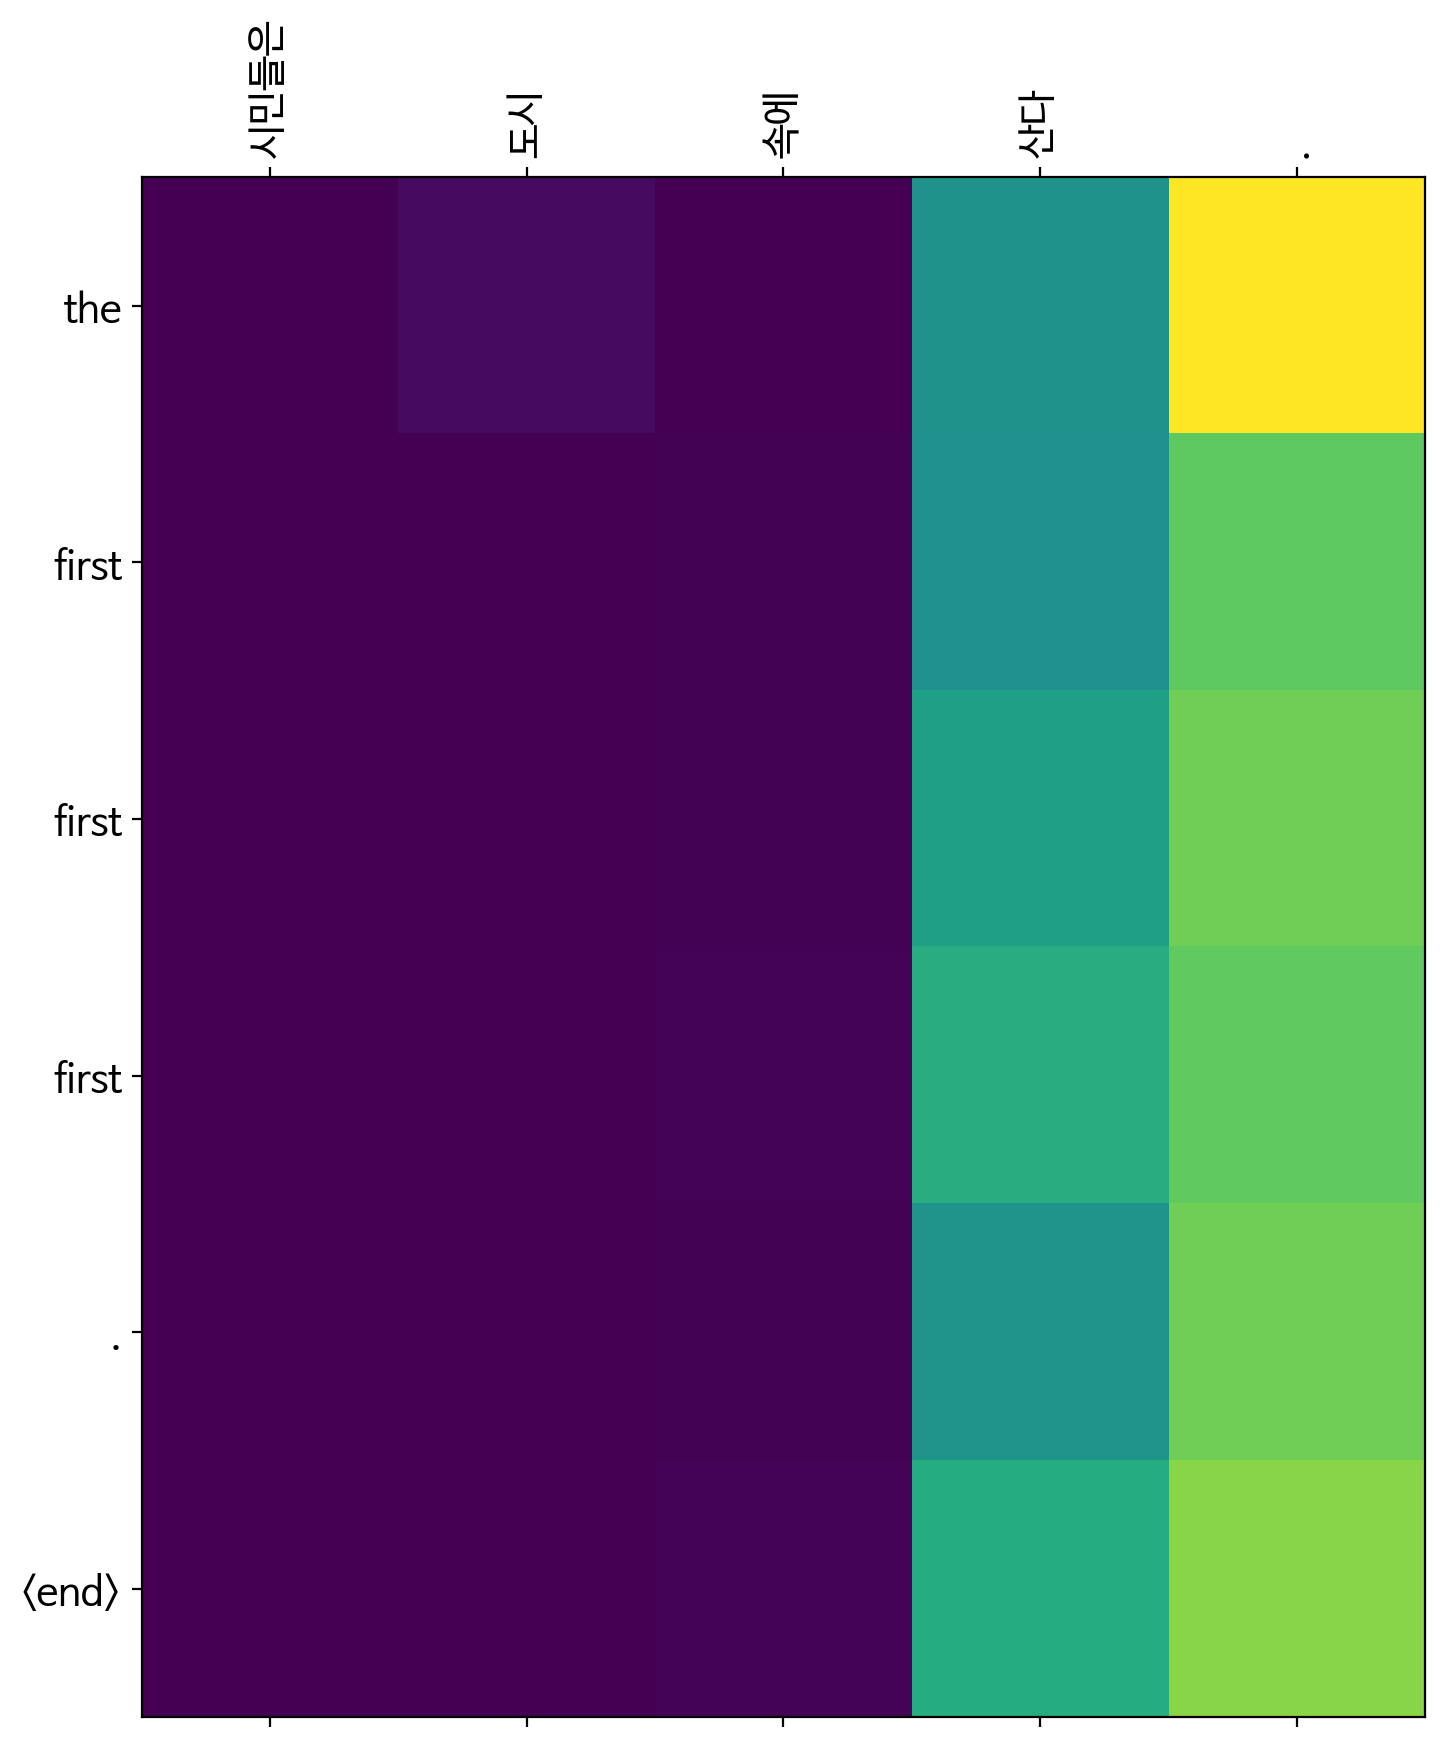

In [61]:
translate("시민들은 도시 속에 산다.", encoder, decoder)

Input: 커피는 필요 없다 .
Predicted translation: the t is a first . <end> 


<ipython-input-60-dc48aaffc8b9>:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-60-dc48aaffc8b9>:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


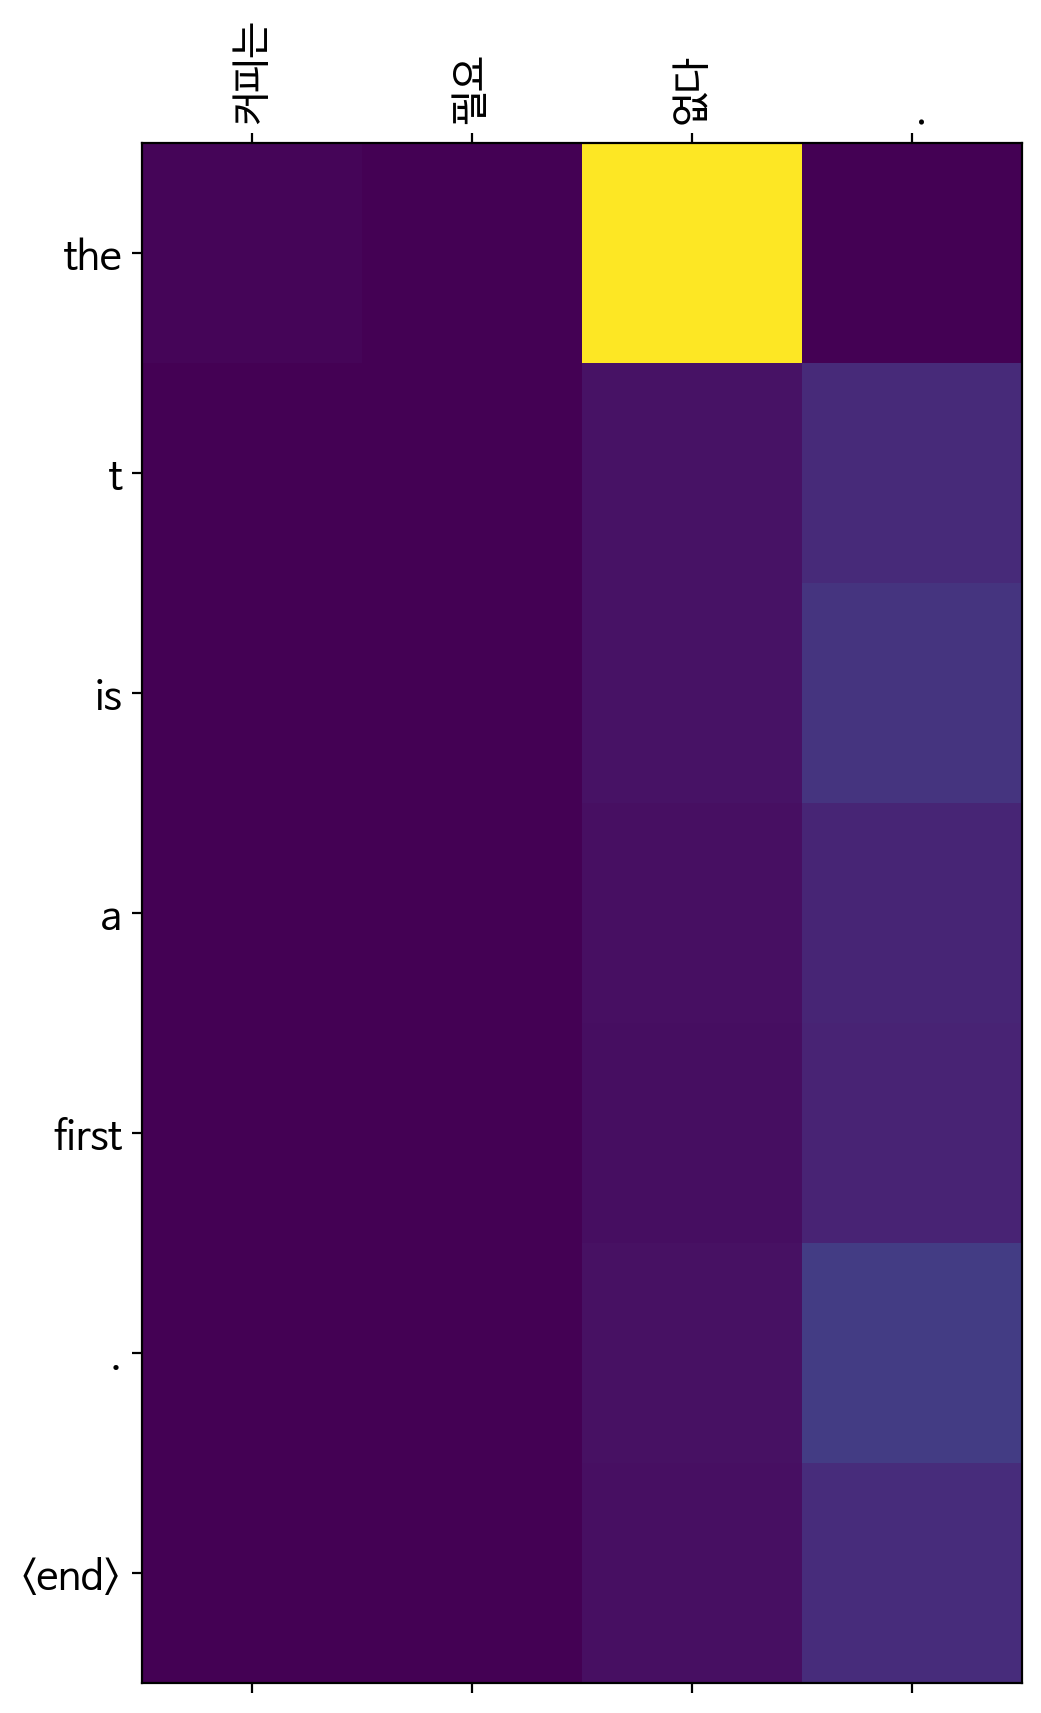

In [62]:
translate("커피는 필요 없다.", encoder, decoder)

Input: 일곱 명의 사망자가 발생했다 .
Predicted translation: the first first first . <end> 


<ipython-input-60-dc48aaffc8b9>:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-60-dc48aaffc8b9>:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


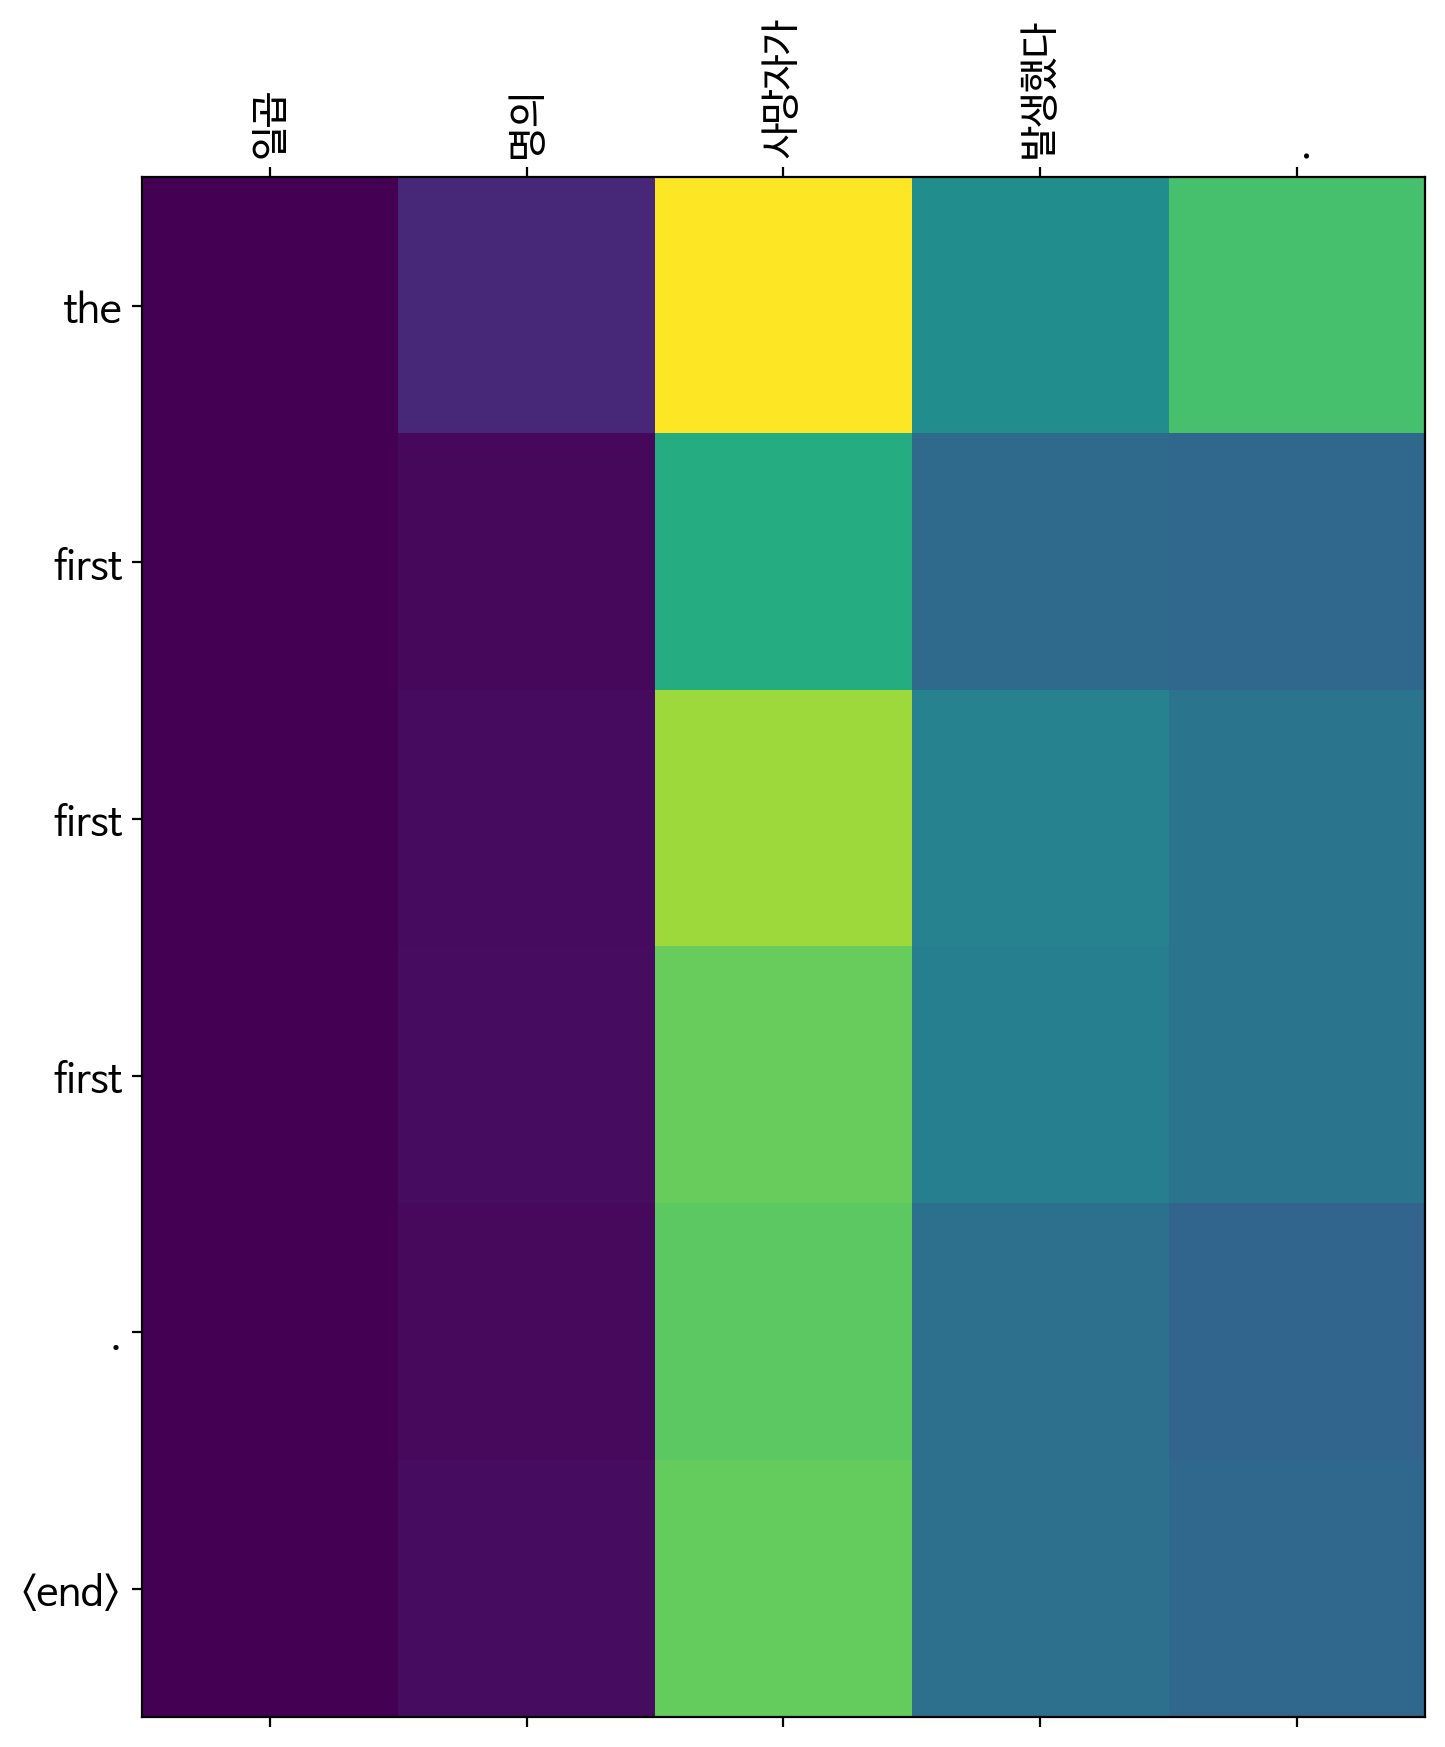

In [63]:
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)